In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [75]:
DF = pd.read_csv('finalData.csv').drop(['Unnamed: 0.1'],axis=1).drop(['Unnamed: 0'],axis=1).drop(['Year'],axis=1).drop(['State'],axis=1)
DF=DF.rename(columns = {'Vehicle Type':'vehicleType'})

In [76]:
DF['City'].value_counts().nlargest(30).sum()

91906

In [77]:
DF['Counts'] = DF.groupby(['City'])['DepreciationRate'].transform('count')
DF = DF.sort_values('Counts',ascending=False)
DF = DF[:91906]

In [78]:
DF['Gdp'].unique()

array([490074,  13820,  76063,  49853, 192177,  10250,   5484,   3937,
       133251,  24395, 535499, 148750,   5441,   8216,   6455, 208868,
        17332, 174029,  22113,  20245,  32143,  16771,  28937,   5991,
       344881,   8027,   8555,  12567], dtype=int64)

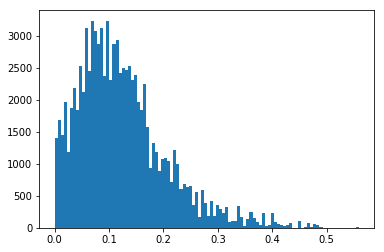

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.hist(DF['DepreciationRate'], bins = 100)
plt.show()

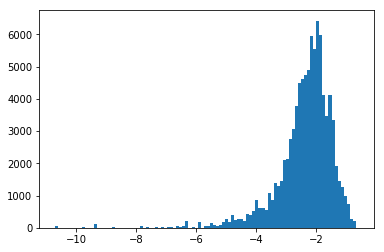

In [80]:
DF['logDepreciationRate']= np.log(DF['DepreciationRate'])
plt.hist(DF['logDepreciationRate'],bins = 100)
plt.show()

In [81]:
DF_dummy = DF.join(pd.get_dummies(DF.vehicleType))
DF_dummy = DF_dummy.drop(['vehicleType'], axis = 1).drop(['Counts'], axis = 1).drop(['DepreciationRate'], axis = 1).drop(['City'], axis = 1).drop(['serviceTime'], axis = 1)
DF_dummy.head(20)

,Mileage,Gdp,Population,logDepreciationRate,SUV,Sedan,Truck
0,126244,490074,2090,-2.342992,0,0,1
5045,105861,490074,2347,-1.733699,1,0,0
5057,22898,490074,2347,-2.024021,0,0,1
5056,105861,490074,2312717,-1.733699,1,0,0
5055,105861,490074,2090,-1.733699,1,0,0
5054,105861,490074,2090,-1.733699,1,0,0
5053,105861,490074,2090,-1.733699,1,0,0
5052,105861,490074,3464,-1.733699,1,0,0
5051,105861,490074,3464,-1.733699,1,0,0
5050,105861,490074,960,-1.733699,1,0,0


In [82]:
currentRegression = []
IndeVari = list(DF_dummy)
IndeVari.remove('logDepreciationRate')

bestAllTimeBic = np.inf
    
while True:
    currentBestBic = np.inf
    toAdd = None
    for vari in IndeVari:
        regTemp = currentRegression[:]
        regTemp.extend([vari])
        currentLm = sm.OLS(DF_dummy.logDepreciationRate, sm.add_constant(DF_dummy[regTemp])).fit()
        currentBic = currentLm.bic
        print ("BIC after adding " + vari + ": "+ str(currentBic))
        if currentBic < currentBestBic:
            toAdd = vari
            currentBestBic = currentBic
    if currentBestBic < bestAllTimeBic:
        print ("Adding " + toAdd + " to model.")
        currentRegression.append(toAdd)        
        print('The independent variables: '+ str(currentRegression))
        IndeVari.remove(toAdd)
        bestAllTimeBic = currentBestBic
    else:
        print ("Get the best (minimum) BIC. Ending forward selection.")
        print()
        print('The final independent variables: '+ str(currentRegression))
        break

BIC after adding Mileage: 251492.67185659506
BIC after adding Gdp: 251668.20540406278
BIC after adding Population: 251722.26962140593
BIC after adding SUV: 251695.31107550283
BIC after adding Sedan: 232143.44351708327
BIC after adding Truck: 233344.85341237712
Adding Sedan to model.
The independent variables: ['Sedan']
BIC after adding Mileage: 231783.96888885312
BIC after adding Gdp: 232118.85960229175
BIC after adding Population: 232151.96861761942
BIC after adding SUV: 227375.32028777842
BIC after adding Truck: 227375.32028777842
Adding SUV to model.
The independent variables: ['Sedan', 'SUV']
BIC after adding Mileage: 226580.73436117868
BIC after adding Gdp: 227347.09341923054
BIC after adding Population: 227383.9116381273
BIC after adding Truck: 227389.96742261073
Adding Mileage to model.
The independent variables: ['Sedan', 'SUV', 'Mileage']
BIC after adding Gdp: 226542.87376770627
BIC after adding Population: 226589.58701088783
BIC after adding Truck: 226580.73436117868
Adding G

In [84]:
lm = smf.ols('logDepreciationRate ~ Sedan+SUV+Mileage+Gdp', data=DF_dummy).fit()
print(lm.summary())

                             OLS Regression Results                            
Dep. Variable:     logDepreciationRate   R-squared:                       0.240
Model:                             OLS   Adj. R-squared:                  0.240
Method:                  Least Squares   F-statistic:                     7256.
Date:                 Thu, 06 Dec 2018   Prob (F-statistic):               0.00
Time:                         02:18:15   Log-Likelihood:            -1.1324e+05
No. Observations:                91906   AIC:                         2.265e+05
Df Residuals:                    91901   BIC:                         2.265e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0565      0.007   -462.20

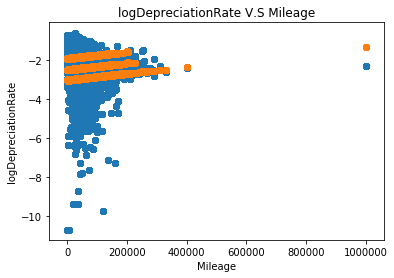

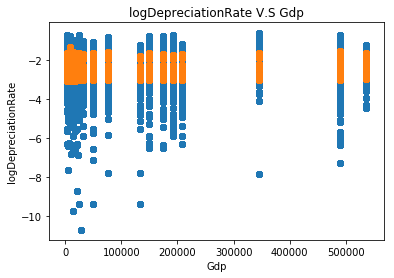

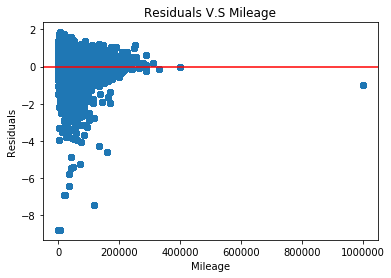

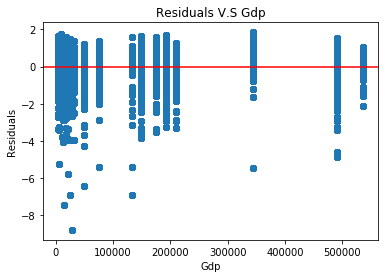

In [87]:
DF_dummy['Prediction'] = lm.predict()
plt.scatter(DF_dummy.Mileage, DF_dummy.logDepreciationRate)
plt.scatter(DF_dummy.Mileage, DF_dummy.Prediction)
plt.xlabel('Mileage')
plt.ylabel('logDepreciationRate')
plt.title('logDepreciationRate V.S Mileage')
plt.show()
DF_dummy['Prediction'] = lm.predict()
plt.scatter(DF_dummy.Gdp, DF_dummy.logDepreciationRate)
plt.scatter(DF_dummy.Gdp, DF_dummy.Prediction)
plt.xlabel('Gdp')
plt.ylabel('logDepreciationRate')
plt.title('logDepreciationRate V.S Gdp')
plt.show()
plt.scatter(DF_dummy.Mileage, DF_dummy.logDepreciationRate-DF_dummy.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage')
plt.show()
plt.scatter(DF_dummy.Gdp, DF_dummy.logDepreciationRate-DF_dummy.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Gdp')
plt.ylabel('Residuals')
plt.title('Residuals V.S Gdp')
plt.show()